# Modelo Dinámico del submarino: 6-DOF

In [1]:
from sympy.physics.mechanics import ReferenceFrame,Point,dynamicsymbols
from sympy.physics.mechanics import Point,RigidBody,inertia, KanesMethod
from sympy import latex,pprint,symbols,init_printing
from sympy.algebras.quaternion import Quaternion
from sympy.physics.mechanics import LagrangesMethod, Lagrangian
from scipy.integrate import odeint
from sympy import lambdify
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import sys 
import sympy
sys.path.append("../tools")
from vis import Visualizer
%matplotlib inline
init_printing() # Para visualizar símbolos

In [2]:
def getComponents(expr,frame,simplify=True):
    if simplify:
        return [expr.dot(frame.x).simplify(),expr.dot(frame.y).simplify(),expr.dot(frame.z).simplify()]
    else:
        return [expr.dot(frame.x),expr.dot(frame.y),expr.dot(frame.z)]

In [3]:
t=symbols('t')
#Parametros inerciales del modelo
[m,Ixx,Iyy,Izz,g]=symbols('m,Ixx,Iyy,Izz,g')
#Parametros geometricos del modelo
[x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,beta1,beta2,beta3,beta4]=symbols('x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,beta1,beta2,beta3,beta4')
#Parametros dinámicos del modelo
[q1,q2,q3,q4,q5,q6]=dynamicsymbols('q1 q2 q3 q4 q5 q6')
q1d,q2d,q3d,q4d,q5d,q6d=dynamicsymbols('q1 q2 q3 q4 q5 q6',1)
q1dd,q2dd,q3dd,q4dd,q5dd,q6dd=dynamicsymbols('q1 q2 q3 q4 q5 q6',2)

#Definir marcos de referencia de importancia
N=ReferenceFrame('N')
A1=N.orientnew('A1','Axis',(q4,N.z))
A2=A1.orientnew('A2','Axis',(q5,A1.y))
A=A2.orientnew('A','Axis',(q6,A2.x))
B1=A.orientnew('B1','Axis',(-beta1,A.z))
B2=A.orientnew('B2','Axis',(beta2,A.z))
B3=A.orientnew('B3','Axis',(-beta3,A.z))
B4=A.orientnew('B4','Axis',(beta4,A.z))
B5=A.orientnew('B6','Axis',(np.deg2rad(90),A.x))
B6=A.orientnew('B6','Axis',(np.deg2rad(90),A.x))

#Definir puntos de interes
O=Point('O')
a=O.locatenew('A',q1*N.x+q2*N.y+q3*N.z)
A.set_ang_vel(A,q4d*N.z+q5d*A1.y+q6d*A2.x)
a.set_vel(N,q1d*N.x+q2d*N.y+q3d*N.z)
b1=a.locatenew('b1',x1*A.x+y1*A.y)
b2=a.locatenew('b2',x2*A.x+y2*A.y)
b3=a.locatenew('b3',x3*A.x+y3*A.y)
b4=a.locatenew('b4',x4*A.x+y4*A.y)
b5=a.locatenew('b5',x5*A.x+y5*A.y)
b6=a.locatenew('b6',x6*A.x+y6*A.y)

In [4]:
A._ang_vel_dict

{A2: Derivative(q6(t), t)*A2.x,
 B1: 0,
 B2: 0,
 B3: 0,
 B4: 0,
 B6: 0,
 B6: 0,
 A: - Derivative(q4(t), t)*N.z - Derivative(q5(t), t)*A1.y - Derivative(q6(t), t)*A2.x}

In [5]:
#Definicion de las fuerzas
[f1,f2,f3,f4,f5,f6]=symbols('f1,f2,f3,f4,f5,f6')
F1=getComponents(f1*B1.y,N)[0]*N.x+getComponents(f1*B1.y,N)[1]*N.y+getComponents(f1*B1.y,N)[2]*N.z
F2=getComponents(f2*B2.y,N)[0]*N.x+getComponents(f2*B2.y,N)[1]*N.y+getComponents(f2*B2.y,N)[2]*N.z
F3=getComponents(f3*B3.y,N)[0]*N.x+getComponents(f3*B3.y,N)[1]*N.y+getComponents(f3*B3.y,N)[2]*N.z
F4=getComponents(f4*B4.y,N)[0]*N.x+getComponents(f4*B4.y,N)[1]*N.y+getComponents(f4*B4.y,N)[2]*N.z
F5=getComponents(f5*B5.y,N)[0]*N.x+getComponents(f5*B5.y,N)[1]*N.y+getComponents(f5*B5.y,N)[2]*N.z
F6=getComponents(f6*B6.y,N)[0]*N.x+getComponents(f6*B6.y,N)[1]*N.y+getComponents(f6*B6.y,N)[2]*N.z

In [6]:
#Se define el cuerpo rigido
inertia_sub=inertia(A,Ixx,Iyy,Izz)
sub = RigidBody('S',a,A,m,(inertia_sub,a))

In [9]:
sub.potential_energy = -m*g*q3
sub.potential_energy

In [7]:
inertia_sub

In [87]:
vel = q1d*N.x+q2d*N.y+q3d*N.z
ang_vel = (q4d*N.z+q5d*A1.y+q6d*A2.x).express(N)
T = sympy.simplify(sympy.Rational(1/2)*m*vel.dot(vel) + sympy.Rational(1/2)*ang_vel.dot(inertia_sub.express(N).dot(ang_vel)))
V = -m*g*q3
L = T - V
L


In [11]:
L=sympy.simplify(Lagrangian(N,sub))
L

In [13]:
ftuples = [(b1,F1),(b2,F2),(b3,F3),(b4,F4),(b5,F5),(b6,F6)]
lm = LagrangesMethod(L,[q1,q2,q3,q4,q5,q6],ftuples,frame=N)
eqs = lm.form_lagranges_equations()

In [16]:
eqs.simplify()

In [17]:
eqs

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [18]:
lm.mass_matrix_full

⎡1  0  0  0  0  0  0  0  0                                                    
⎢                                                                             
⎢0  1  0  0  0  0  0  0  0                                                    
⎢                                                                             
⎢0  0  1  0  0  0  0  0  0                                                    
⎢                                                                             
⎢0  0  0  1  0  0  0  0  0                                                    
⎢                                                                             
⎢0  0  0  0  1  0  0  0  0                                                    
⎢                                                                             
⎢0  0  0  0  0  1  0  0  0                                                    
⎢                                                                             
⎢0  0  0  0  0  0  m  0  0                          

In [20]:
sympy.simplify(lm.forcing_full)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [21]:
rhs = lm.rhs()

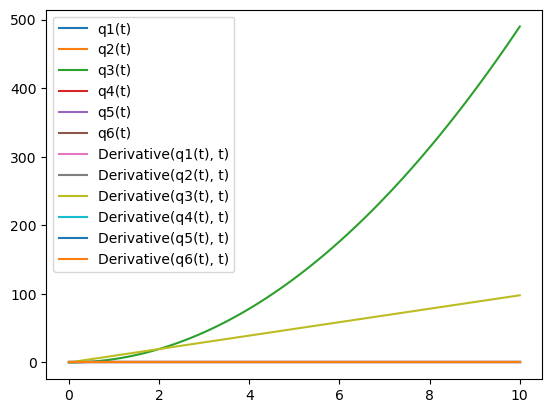

In [35]:
# Finalmente puede utilizar el modelo del sistema para realizar simulaciones
# de dinamica directa utilizando un integrador de ecuaciones diferenciales
# de primer orden.

# Defina las condiciones iniciales del sistema
x0=[0,0,0,0,0,0,0,0,0,0,0,0]
# Asigne valores numericos a los parámetros del modelo
# rhs.free_symbols (revise las variables libres del modelo)
parameters={f1:0,f2:0,f3:0,f4:0,f5:0,f6:0,m:4,Ixx:1064.294e-4,Iyy:1577.872e-4,Izz:951.955e-4,
            x1:-0.20,x2:0.20,x3:0.20,x4:-0.20,x5:-0.4,x6:0.4,
            y1:0.20,y2:0.20,y3:-0.20,y4:-0.20,y5:0,y6:0,
            beta1:np.deg2rad(45),beta2:np.deg2rad(45),beta3:np.deg2rad(45),
            beta4:np.deg2rad(45),g:9.8}

#Modifique los valores de M1 y M2 para obtener diferentes resultados en
# la simulación
parameters[f1]=0#-0.1*q1d-0.1*(q1-0.5)
parameters[f2]=0#-0.1*q2d-0.1*(q2-0.5)
parameters[f3]=0
parameters[f4]=0
parameters[f5]=0.000001
parameters[f6]=0.000001


t=np.linspace(0,10,100)
# Cree una función numérica del modelo del sistema (i.e xdot=f(x))
rhs_fun=lambdify([q1,q2,q3,q4,q5,q6,q1d,q2d,q3d,q4d,q5d,q6d],rhs.subs(parameters))
ode_fun=lambda x,t: rhs_fun(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11]).reshape(12)
x=odeint(ode_fun,x0,t)

plt.figure()
plt.plot(t,x)
plt.legend([q1,q2,q3,q4,q5,q6,q1d,q2d,q3d,q4d,q5d,q6d])
plt.show()

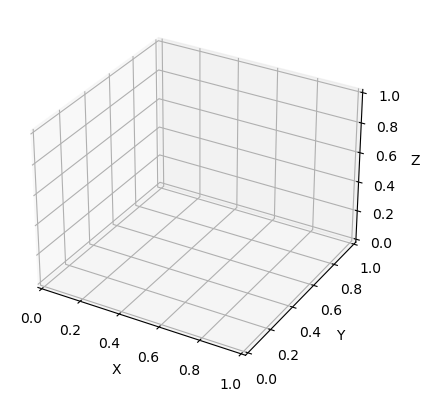

MovieWriter ffmpeg unavailable; using Pillow instead.


In [36]:
vis=Visualizer(N,O)
vis.add(A,a,shape='sub.stl')
vis.add(A,a,frame_scale=100)


vis.plot({q1:x0[0],q2:x0[0],q3:x0[0],q4:x0[0],q5:x0[0],q6:x0[0]})
vis.fig.savefig('plot1.png')

def update(i,data):
    vis.plot({q1:data[i,0],q2:data[i,1],q3:data[i,2],q4:data[i,3],q5:data[i,4],q6:data[i,5]})
    
ani = animation.FuncAnimation(vis.fig, update, x.shape[0], fargs=(x,), interval=10/x.shape[0], blit=False)
ani.save('animation1.gif',fps=20)